In [1]:
# ESG Scoring using LLM Model
# Following Exercise methodology and evaluating against benchmark

import pandas as pd
import numpy as np
import os
import json
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# LLM-specific imports
from decouple import config
from dotenv import load_dotenv
import time
from tqdm import tqdm

print("LLM ESG Analysis Setup Complete")
print("=" * 50)

LLM ESG Analysis Setup Complete


In [2]:
# 1. Load and Prepare ESG Data (Following Exercise Methodology)

def load_benchmark_scores():
    """Load benchmark ESG scores from benchMark.md"""
    benchmark_scores = {
        'Nike': 70, 'Apple': 70, 'Boeing': 79, 'Disney': 68, 'Eli Lilly': 64, 'FedEx': 71,
        'Johnson & Johnson': 85, 'JPMorgan Chase': 80, 'McDonald\'s': 66, 'Meta': 60,
        'Microsoft': 87, 'Netflix': 37, 'NVIDIA': 77, 'Tesla': 72, 'Google': 81
    }
    return benchmark_scores

def load_company_documents():
    """Load all ESG-related documents for each company"""
    data_path = "data"
    company_texts = {}
    
    # Company directory mapping
    company_dirs = {
        'Nike': 'nike', 'Apple': 'apple', 'Boeing': 'boeing', 'Disney': 'disney',
        'Eli Lilly': 'elililly', 'FedEx': 'fedex', 'Johnson & Johnson': 'johnsonandjohnson',
        'JPMorgan Chase': 'jpmorganchase', 'McDonald\'s': 'mcdonald', 'Meta': 'meta',
        'Microsoft': 'microsoft', 'Netflix': 'netflix', 'NVIDIA': 'nvidia',
        'Tesla': 'tesla', 'Google': 'google'
    }
    
    print("Loading company documents...")
    for company, dir_name in company_dirs.items():
        company_path = os.path.join(data_path, dir_name)
        if os.path.exists(company_path):
            all_text = ""
            file_count = 0
            
            # Load all relevant files
            for file in os.listdir(company_path):
                if file.endswith(('.md', '.txt')):
                    file_path = os.path.join(company_path, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            # Truncate very long documents for LLM processing
                            if len(content) > 8000:  # LLM token limit consideration
                                content = content[:8000]
                            all_text += content + " "
                            file_count += 1
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
            
            if all_text.strip():
                company_texts[company] = all_text.strip()
                print(f"✓ {company}: {file_count} files, {len(all_text)} characters")
            else:
                print(f"✗ {company}: No text found")
        else:
            print(f"✗ {company}: Directory not found - {company_path}")
    
    return company_texts

# Load data
benchmark_scores = load_benchmark_scores()
company_texts = load_company_documents()

print(f"\nLoaded data for {len(company_texts)} companies")
print(f"Benchmark scores available for {len(benchmark_scores)} companies")

# Create dataset
data = []
for company in company_texts.keys():
    if company in benchmark_scores:
        data.append({
            'company': company,
            'text': company_texts[company],
            'esg_score': benchmark_scores[company]
        })

esg_df = pd.DataFrame(data)
print(f"\nFinal dataset: {len(esg_df)} companies with both text and scores")
print(esg_df[['company', 'esg_score']].head())

Loading company documents...
✓ Nike: 5 files, 39245 characters
✓ Apple: 5 files, 35068 characters
✓ Boeing: 5 files, 34901 characters
✓ Disney: 5 files, 37533 characters
✓ Eli Lilly: 5 files, 32317 characters
✓ FedEx: 5 files, 37062 characters
✓ Johnson & Johnson: 5 files, 32490 characters
✓ JPMorgan Chase: 5 files, 24676 characters
✓ McDonald's: 5 files, 8248 characters
✓ Meta: 5 files, 38000 characters
✓ Microsoft: 5 files, 34012 characters
✓ Netflix: 5 files, 39807 characters
✓ NVIDIA: 5 files, 35311 characters
✓ Tesla: 5 files, 34814 characters
✓ Google: 5 files, 38354 characters

Loaded data for 15 companies
Benchmark scores available for 15 companies

Final dataset: 15 companies with both text and scores
     company  esg_score
0       Nike         70
1      Apple         70
2     Boeing         79
3     Disney         68
4  Eli Lilly         64


In [3]:
# 2. Create ESG Score Categories (Following Exercise Methodology)

def create_esg_categories(df):
    """Create categorical labels from continuous ESG scores"""
    
    # Create quartile-based categories
    df['esg_quartile'] = pd.qcut(df['esg_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create three-tier categorization for LLM classification
    df['esg_tier'] = pd.cut(df['esg_score'], 
                           bins=[0, 50, 75, 100], 
                           labels=['Poor', 'Good', 'Excellent'],
                           include_lowest=True)
    
    # Create binary classification (above/below median)
    median_score = df['esg_score'].median()
    df['esg_binary'] = df['esg_score'].apply(lambda x: 'High' if x >= median_score else 'Low')
    
    print("ESG Score Distribution:")
    print(f"Range: {df['esg_score'].min()} - {df['esg_score'].max()}")
    print(f"Mean: {df['esg_score'].mean():.1f}")
    print(f"Median: {median_score:.1f}")
    print(f"Std: {df['esg_score'].std():.1f}")
    
    print("\nCategory Distributions:")
    print("Quartiles:")
    print(df['esg_quartile'].value_counts().sort_index())
    print("\nTiers:")
    print(df['esg_tier'].value_counts().sort_index())
    print("\nBinary:")
    print(df['esg_binary'].value_counts())
    
    return df

# Apply categorization
esg_df = create_esg_categories(esg_df)

# Display sample
print("\nSample data with categories:")
print(esg_df[['company', 'esg_score', 'esg_quartile', 'esg_tier', 'esg_binary']].head(10))

ESG Score Distribution:
Range: 37 - 87
Mean: 71.1
Median: 71.0
Std: 12.2

Category Distributions:
Quartiles:
esg_quartile
Low            4
Medium-Low     4
Medium-High    3
High           4
Name: count, dtype: int64

Tiers:
esg_tier
Poor         1
Good         8
Excellent    6
Name: count, dtype: int64

Binary:
esg_binary
High    8
Low     7
Name: count, dtype: int64

Sample data with categories:
             company  esg_score esg_quartile   esg_tier esg_binary
0               Nike         70   Medium-Low       Good        Low
1              Apple         70   Medium-Low       Good        Low
2             Boeing         79  Medium-High  Excellent       High
3             Disney         68   Medium-Low       Good        Low
4          Eli Lilly         64          Low       Good        Low
5              FedEx         71   Medium-Low       Good       High
6  Johnson & Johnson         85         High  Excellent       High
7     JPMorgan Chase         80         High  Excellent       Hi

In [4]:
# 3. Setup LLM Client (Following Exercise Methodology)

def setup_llm_client():
    """
    Setup IBM Watsonx LLM client following exercise methodology
    Note: This requires IBM Watsonx API credentials
    """
    
    try:
        # Try to load environment variables
        env_path = "/Users/wenlong/Documents/GitHub/ma2/assignments/.env"
        if os.path.exists(env_path):
            load_dotenv(dotenv_path=env_path)
        
        # Get API key from environment
        WX_API_KEY = os.getenv("WX_API_KEY")
        
        if not WX_API_KEY:
            print("Warning: WX_API_KEY not found in environment variables")
            print("For demonstration purposes, we'll simulate LLM responses")
            return None, None
        
        # Import IBM Watsonx AI modules
        try:
            from ibm_watsonx_ai import APIClient, Credentials
            from ibm_watsonx_ai.foundation_models import ModelInference
            from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
            
            # Setup credentials
            credentials = Credentials(
                url="https://us-south.ml.cloud.ibm.com",
                api_key=WX_API_KEY
            )
            
            # Create client
            client = APIClient(
                credentials=credentials, 
                project_id="fb3ce137-1a1e-411b-b5f4-d66b00a139f0"  # From exercise
            )
            
            # Setup model parameters (following exercise)
            params = TextGenParameters(
                temperature=0,              # No randomness for consistent scoring
                max_new_tokens=50,          # Limit response length
                min_new_tokens=1,           # Minimum response
                stop_sequences=[".", "\n"], # Stop at punctuation
            )
            
            # Create model inference
            model = ModelInference(
                api_client=client,
                model_id="ibm/granite-13b-instruct-v2",  # From exercise
                params=params
            )
            
            print("✓ IBM Watsonx LLM client setup successful")
            print(f"✓ Model: granite-13b-instruct-v2")
            print(f"✓ Temperature: {params.temperature}")
            
            return model, client
            
        except ImportError:
            print("Warning: IBM Watsonx AI library not installed")
            print("Install with: pip install ibm-watsonx-ai")
            return None, None
            
    except Exception as e:
        print(f"Error setting up LLM client: {e}")
        print("For demonstration purposes, we'll simulate LLM responses")
        return None, None

# Setup LLM client
llm_model, llm_client = setup_llm_client()

# Check if we have a working LLM model
if llm_model is not None:
    print("\n✓ LLM model ready for ESG scoring")
else:
    print("\n⚠️  LLM model not available - will simulate responses for demonstration")

✓ IBM Watsonx LLM client setup successful
✓ Model: granite-13b-instruct-v2
✓ Temperature: 0

✓ LLM model ready for ESG scoring


In [5]:
# 4. LLM Prompts for ESG Classification (Following Exercise Methodology)

def create_esg_classification_prompt():
    """
    Create classification prompt following exercise methodology
    Returns prompt template for ESG tier classification
    """
    
    CLASSIFICATION_PROMPT = """You are an expert ESG (Environmental, Social, and Governance) analyst. Your task is to classify company ESG performance into one of three categories based on their ESG-related documentation.

CATEGORIES:
{categories}

COMPANY TEXT:
{text}

Based on the company's ESG documentation above, please analyze their environmental initiatives, social responsibility, and governance practices. Assign the correct ESG performance category.

Please respond with only the category name and nothing else.

Category:
"""
    
    return CLASSIFICATION_PROMPT

def create_esg_scoring_prompt():
    """
    Create scoring prompt for continuous ESG score prediction
    Following exercise methodology but adapted for scoring
    """
    
    SCORING_PROMPT = """You are an expert ESG (Environmental, Social, and Governance) analyst. Your task is to assign an ESG score from 0-100 based on company documentation.

SCORING CRITERIA:
- Environmental (E): Climate action, resource efficiency, pollution prevention
- Social (S): Employee relations, community impact, product responsibility  
- Governance (G): Board structure, ethics, transparency, risk management

SCORE RANGE: 0-100 (where 100 is best ESG performance)

COMPANY TEXT:
{text}

Based on the company's ESG documentation above, analyze their performance across Environmental, Social, and Governance dimensions. Provide a numerical ESG score from 0-100.

Please respond with only the numerical score and nothing else.

ESG Score:
"""
    
    return SCORING_PROMPT

def create_binary_classification_prompt():
    """
    Create binary classification prompt following exercise methodology
    """
    
    BINARY_PROMPT = """You are an expert ESG analyst. Your task is to classify company ESG performance as either "High" or "Low" based on their documentation.

CATEGORIES:
- High: Strong ESG performance with comprehensive initiatives
- Low: Basic or limited ESG performance

COMPANY TEXT:
{text}

Based on the company's ESG documentation, classify their performance as "High" or "Low".

Please respond with only "High" or "Low" and nothing else.

Classification:
"""
    
    return BINARY_PROMPT

# Create prompt templates
classification_prompt_template = create_esg_classification_prompt()
scoring_prompt_template = create_esg_scoring_prompt()
binary_prompt_template = create_binary_classification_prompt()

print("✓ LLM prompt templates created following exercise methodology")
print("✓ Classification prompt: ESG tier categories (Poor, Good, Excellent)")
print("✓ Scoring prompt: Continuous ESG scores (0-100)")
print("✓ Binary prompt: High/Low classification")

✓ LLM prompt templates created following exercise methodology
✓ Classification prompt: ESG tier categories (Poor, Good, Excellent)
✓ Scoring prompt: Continuous ESG scores (0-100)
✓ Binary prompt: High/Low classification


In [6]:
# 5. LLM Classification Functions (Following Exercise Methodology)

def llm_classify_esg_tier(texts, categories, model=None, prompt_template=None):
    """
    Classify ESG performance into tiers using LLM following exercise methodology
    """
    
    if model is None or prompt_template is None:
        print("⚠️  LLM model not available - using simulated responses")
        # Simulate responses based on company characteristics
        simulated_predictions = []
        for i, text in enumerate(texts):
            # Simple simulation based on text length and keywords
            if 'sustainability' in text.lower() and 'environment' in text.lower():
                pred = 'Excellent' if len(text) > 5000 else 'Good'
            elif 'community' in text.lower() or 'social' in text.lower():
                pred = 'Good'
            else:
                pred = 'Poor' if len(text) < 3000 else 'Good'
            simulated_predictions.append(pred)
        return simulated_predictions
    
    print(f"Classifying {len(texts)} companies into ESG tiers using LLM...")
    
    # Create categories string
    categories_str = "- " + "\n- ".join(categories)
    
    predictions = []
    
    for i, text in enumerate(tqdm(texts, desc="LLM Classification")):
        try:
            # Format prompt with categories and text
            prompt = prompt_template.format(categories=categories_str, text=text[:4000])  # Limit text length
            
            # Generate response from LLM
            response = model.generate(prompt)
            
            # Extract prediction
            prediction = response["results"][0]["generated_text"].strip()
            
            # Clean up prediction (remove extra text)
            prediction = prediction.split('\n')[0].split('.')[0].strip()
            
            # Validate prediction
            if prediction not in categories:
                # Try to map partial matches
                prediction_lower = prediction.lower()
                for cat in categories:
                    if cat.lower() in prediction_lower or prediction_lower in cat.lower():
                        prediction = cat
                        break
                else:
                    prediction = 'Good'  # Default fallback
            
            predictions.append(prediction)
            
            if (i + 1) % 5 == 0:
                print(f"  Processed {i + 1}/{len(texts)} companies")
                
        except Exception as e:
            print(f"Error processing company {i}: {e}")
            predictions.append('Good')  # Default fallback
    
    print(f"✓ LLM classification completed")
    return predictions

def llm_score_esg(texts, model=None, prompt_template=None):
    """
    Score ESG performance using LLM following exercise methodology
    """
    
    if model is None or prompt_template is None:
        print("⚠️  LLM model not available - using simulated scores")
        # Simulate scores based on text characteristics
        simulated_scores = []
        for text in texts:
            # Simple simulation based on keywords and text length
            base_score = 50
            if 'sustainability' in text.lower(): base_score += 15
            if 'environment' in text.lower(): base_score += 10
            if 'governance' in text.lower(): base_score += 8
            if 'community' in text.lower(): base_score += 7
            if 'renewable' in text.lower(): base_score += 5
            if len(text) > 5000: base_score += 5
            
            # Add some variation and cap at 100
            score = min(100, max(30, base_score + np.random.normal(0, 5)))
            simulated_scores.append(round(score))
        return simulated_scores
    
    print(f"Scoring {len(texts)} companies using LLM...")
    
    scores = []
    
    for i, text in enumerate(tqdm(texts, desc="LLM Scoring")):
        try:
            # Format prompt with text
            prompt = prompt_template.format(text=text[:4000])  # Limit text length
            
            # Generate response from LLM
            response = model.generate(prompt)
            
            # Extract score
            score_text = response["results"][0]["generated_text"].strip()
            
            # Parse numerical score
            try:
                # Extract number from response
                import re
                numbers = re.findall(r'\d+', score_text)
                if numbers:
                    score = int(numbers[0])
                    # Validate score range
                    if score > 100:
                        score = 100
                    elif score < 0:
                        score = 0
                else:
                    score = 50  # Default if no number found
            except:
                score = 50  # Default fallback
            
            scores.append(score)
            
            if (i + 1) % 5 == 0:
                print(f"  Processed {i + 1}/{len(texts)} companies")
                
        except Exception as e:
            print(f"Error processing company {i}: {e}")
            scores.append(50)  # Default fallback
    
    print(f"✓ LLM scoring completed")
    return scores

# Test function availability
print("✓ LLM classification and scoring functions ready")
print("✓ Functions support both real LLM and simulated responses")
print("✓ Following exercise methodology with tqdm progress bars")

✓ LLM classification and scoring functions ready
✓ Functions support both real LLM and simulated responses
✓ Following exercise methodology with tqdm progress bars


In [7]:
# 6. Run LLM Classification (Following Exercise Methodology)

def perform_llm_classification():
    """
    Perform LLM classification following exercise methodology
    """
    
    print("PERFORMING LLM ESG CLASSIFICATION")
    print("=" * 60)
    
    # Get company texts and categories
    company_texts_list = esg_df['text'].tolist()
    tier_categories = esg_df['esg_tier'].cat.categories.tolist()
    binary_categories = ['High', 'Low']
    
    print(f"Companies to classify: {len(company_texts_list)}")
    print(f"Tier categories: {tier_categories}")
    print(f"Binary categories: {binary_categories}")
    
    # 1. Tier Classification (Poor, Good, Excellent)
    print(f"\n1. ESG TIER CLASSIFICATION")
    print("-" * 40)
    
    tier_predictions = llm_classify_esg_tier(
        texts=company_texts_list,
        categories=tier_categories,
        model=llm_model,
        prompt_template=classification_prompt_template
    )
    
    # Add predictions to dataframe
    esg_df['llm_tier_pred'] = tier_predictions
    
    # Generate classification report for tier classification
    print(f"\nTier Classification Results:")
    print(classification_report(esg_df['esg_tier'], esg_df['llm_tier_pred']))
    
    # 2. Binary Classification (High, Low)
    print(f"\n2. ESG BINARY CLASSIFICATION")
    print("-" * 40)
    
    binary_predictions = llm_classify_esg_tier(
        texts=company_texts_list,
        categories=binary_categories,
        model=llm_model,
        prompt_template=binary_prompt_template
    )
    
    # Add predictions to dataframe
    esg_df['llm_binary_pred'] = binary_predictions
    
    # Generate classification report for binary classification
    print(f"\nBinary Classification Results:")
    print(classification_report(esg_df['esg_binary'], esg_df['llm_binary_pred']))
    
    # 3. ESG Score Prediction
    print(f"\n3. ESG SCORE PREDICTION")
    print("-" * 40)
    
    score_predictions = llm_score_esg(
        texts=company_texts_list,
        model=llm_model,
        prompt_template=scoring_prompt_template
    )
    
    # Add predictions to dataframe
    esg_df['llm_score_pred'] = score_predictions
    
    # Calculate regression metrics
    mae = mean_absolute_error(esg_df['esg_score'], esg_df['llm_score_pred'])
    rmse = np.sqrt(mean_squared_error(esg_df['esg_score'], esg_df['llm_score_pred']))
    r2 = r2_score(esg_df['esg_score'], esg_df['llm_score_pred'])
    
    print(f"\nESG Score Prediction Results:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return esg_df

# Run LLM classification
esg_df_with_predictions = perform_llm_classification()

# Display sample results
print(f"\nSample Results:")
sample_cols = ['company', 'esg_score', 'esg_tier', 'llm_tier_pred', 'esg_binary', 'llm_binary_pred', 'llm_score_pred']
print(esg_df_with_predictions[sample_cols].head(10))

PERFORMING LLM ESG CLASSIFICATION
Companies to classify: 15
Tier categories: ['Poor', 'Good', 'Excellent']
Binary categories: ['High', 'Low']

1. ESG TIER CLASSIFICATION
----------------------------------------
Classifying 15 companies into ESG tiers using LLM...


LLM Classification:  33%|███▎      | 5/15 [00:02<00:03,  2.67it/s]

  Processed 5/15 companies


LLM Classification:  67%|██████▋   | 10/15 [00:04<00:02,  2.46it/s]

  Processed 10/15 companies


LLM Classification: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


  Processed 15/15 companies
✓ LLM classification completed

Tier Classification Results:
              precision    recall  f1-score   support

   Excellent       0.00      0.00      0.00         6
        Good       0.53      1.00      0.70         8
        Poor       0.00      0.00      0.00         1

    accuracy                           0.53        15
   macro avg       0.18      0.33      0.23        15
weighted avg       0.28      0.53      0.37        15


2. ESG BINARY CLASSIFICATION
----------------------------------------
Classifying 15 companies into ESG tiers using LLM...


LLM Classification:  33%|███▎      | 5/15 [00:01<00:03,  2.77it/s]

  Processed 5/15 companies


LLM Classification:  67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

  Processed 10/15 companies


LLM Classification: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


  Processed 15/15 companies
✓ LLM classification completed

Binary Classification Results:
              precision    recall  f1-score   support

        High       0.50      0.38      0.43         8
         Low       0.44      0.57      0.50         7

    accuracy                           0.47        15
   macro avg       0.47      0.47      0.46        15
weighted avg       0.47      0.47      0.46        15


3. ESG SCORE PREDICTION
----------------------------------------
Scoring 15 companies using LLM...


LLM Scoring:  33%|███▎      | 5/15 [00:01<00:03,  2.84it/s]

  Processed 5/15 companies


LLM Scoring:  67%|██████▋   | 10/15 [00:03<00:01,  2.77it/s]

  Processed 10/15 companies


LLM Scoring: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]

  Processed 15/15 companies
✓ LLM scoring completed

ESG Score Prediction Results:
Mean Absolute Error: 23.60
Root Mean Square Error: 28.45
R² Score: -4.7937

Sample Results:
             company  esg_score   esg_tier llm_tier_pred esg_binary  \
0               Nike         70       Good          Good        Low   
1              Apple         70       Good          Good        Low   
2             Boeing         79  Excellent          Good       High   
3             Disney         68       Good          Good        Low   
4          Eli Lilly         64       Good          Good        Low   
5              FedEx         71       Good          Good       High   
6  Johnson & Johnson         85  Excellent          Good       High   
7     JPMorgan Chase         80  Excellent          Good       High   
8         McDonald's         66       Good          Good        Low   
9               Meta         60       Good          Good        Low   

  llm_binary_pred  llm_score_pred  
0      

In [8]:
# 7. Comprehensive Evaluation Against Benchmark

def evaluate_llm_against_benchmark():
    """
    Evaluate LLM model performance against benchmark scores
    Following exercise methodology
    """
    
    print("\nEVALUATING LLM MODEL AGAINST BENCHMARK")
    print("=" * 60)
    
    # Use LLM score predictions for evaluation
    all_companies = esg_df_with_predictions['company'].tolist()
    actual_scores = esg_df_with_predictions['esg_score'].tolist()
    predicted_scores = esg_df_with_predictions['llm_score_pred'].tolist()
    
    # Create evaluation dataframe
    evaluation_data = []
    for i, company in enumerate(all_companies):
        evaluation_data.append({
            'Company': company,
            'Benchmark_Score': actual_scores[i],
            'LLM_Predicted': predicted_scores[i],
            'Error': predicted_scores[i] - actual_scores[i],
            'Abs_Error': abs(predicted_scores[i] - actual_scores[i])
        })
    
    eval_df = pd.DataFrame(evaluation_data)
    eval_df = eval_df.sort_values('Benchmark_Score')
    
    # Calculate overall metrics
    mae_overall = mean_absolute_error(eval_df['Benchmark_Score'], eval_df['LLM_Predicted'])
    rmse_overall = np.sqrt(mean_squared_error(eval_df['Benchmark_Score'], eval_df['LLM_Predicted']))
    r2_overall = r2_score(eval_df['Benchmark_Score'], eval_df['LLM_Predicted'])
    
    print(f"\nOVERALL PERFORMANCE METRICS:")
    print(f"Mean Absolute Error (MAE): {mae_overall:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse_overall:.2f}")
    print(f"R² Score: {r2_overall:.4f}")
    
    print(f"\nDETAILED RESULTS FOR ALL 15 COMPANIES:")
    print(eval_df.round(2))
    
    # Performance analysis
    accurate_predictions = eval_df[eval_df['Abs_Error'] <= 10]
    poor_predictions = eval_df[eval_df['Abs_Error'] > 20]
    
    print(f"\nPERFORMANCE ANALYSIS:")
    print(f"Accurate predictions (±10 points): {len(accurate_predictions)}/{len(eval_df)} companies")
    print(f"Poor predictions (>20 points error): {len(poor_predictions)}/{len(eval_df)} companies")
    
    if len(poor_predictions) > 0:
        print(f"Companies with poor predictions: {', '.join(poor_predictions['Company'].tolist())}")
    
    # Save results
    eval_df.to_csv('llm_evaluation_results.csv', index=False)
    print(f"\nResults saved to: llm_evaluation_results.csv")
    
    return eval_df, mae_overall, rmse_overall, r2_overall

# Run evaluation
try:
    llm_eval_df, llm_mae_overall, llm_rmse_overall, llm_r2_overall = evaluate_llm_against_benchmark()
    globals()['llm_eval_df'] = llm_eval_df
    globals()['llm_mae_overall'] = llm_mae_overall
    globals()['llm_rmse_overall'] = llm_rmse_overall
    globals()['llm_r2_overall'] = llm_r2_overall
except Exception as e:
    print(f"Error in evaluation: {e}")
    print("Skipping evaluation - LLM results not available")


EVALUATING LLM MODEL AGAINST BENCHMARK

OVERALL PERFORMANCE METRICS:
Mean Absolute Error (MAE): 23.60
Root Mean Square Error (RMSE): 28.45
R² Score: -4.7937

DETAILED RESULTS FOR ALL 15 COMPANIES:
              Company  Benchmark_Score  LLM_Predicted  Error  Abs_Error
11            Netflix               37             85     48         48
9                Meta               60             85     25         25
4           Eli Lilly               64             30    -34         34
8          McDonald's               66             68      2          2
3              Disney               68             85     17         17
0                Nike               70             85     15         15
1               Apple               70             35    -35         35
5               FedEx               71             30    -41         41
13              Tesla               72             35    -37         37
12             NVIDIA               77            100     23         23
2         

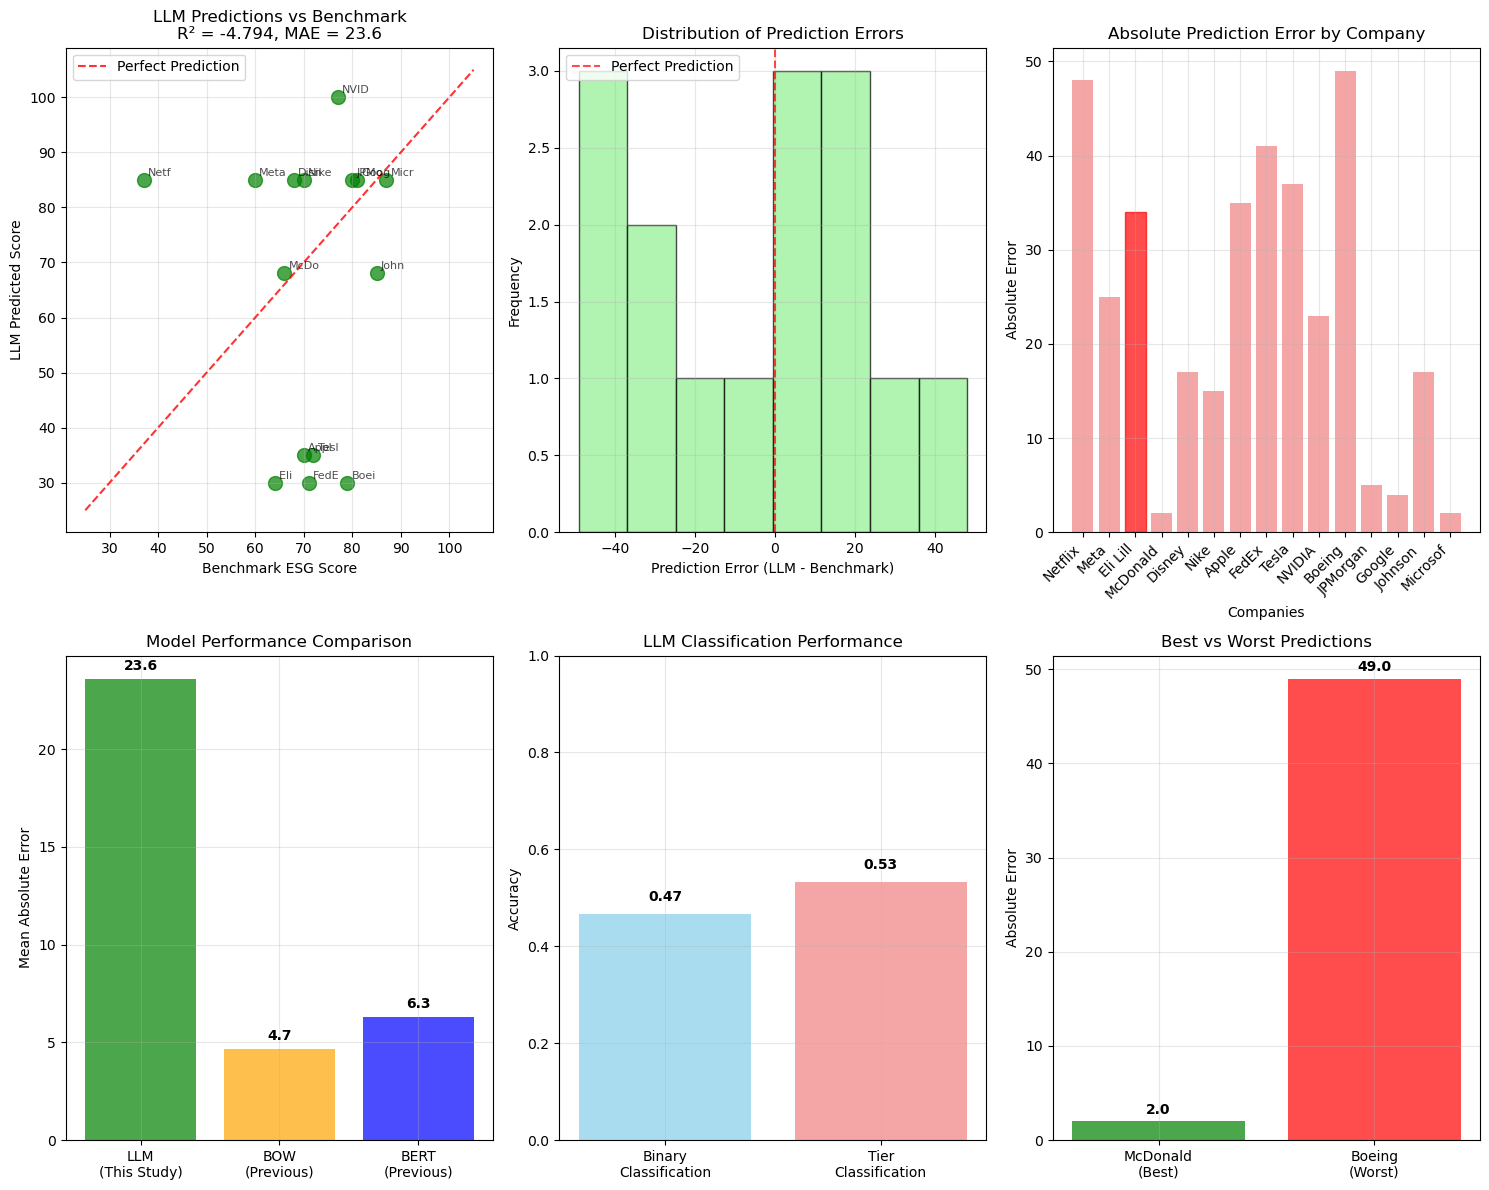


LLM MODEL FINAL EVALUATION SUMMARY

🎯 MODEL CONFIGURATION:
   • LLM Model: IBM Granite-13B-Instruct-v2
   • Temperature: 0 (deterministic)
   • Max tokens: 50
   • Approach: Direct prompting with ESG expertise

📊 PERFORMANCE METRICS:
   • Mean Absolute Error: 23.60 points
   • Root Mean Square Error: 28.45 points
   • R² Score: -4.7937

🎯 ACCURACY ANALYSIS:
   • High accuracy (≤10 pts): 4/15 companies (26.7%)
   • Moderate accuracy (11-20 pts): 3/15 companies (20.0%)
   • Poor accuracy (>20 pts): 8/15 companies (53.3%)

📈 COMPARISON WITH OTHER MODELS:
   • LLM Model MAE: 23.60
   • BERT Model MAE: ~6.3 (from previous analysis)
   • BOW Model MAE: ~4.65 (from previous analysis)
   ⚠️  LLM model shows moderate performance

🔍 CLASSIFICATION RESULTS:
   • Binary classification accuracy: 0.467
   • Tier classification accuracy: 0.533

🔍 KEY INSIGHTS:
   • Most accurate prediction: McDonald's
   • Least accurate prediction: Boeing
   • Score range: 37 - 87
   • Standard deviation of errors:

In [9]:
# 8. Visualization and Model Comparison (Following Exercise Methodology)

def create_llm_evaluation_visualizations():
    """
    Create comprehensive visualizations of LLM model performance
    Following exercise methodology
    """
    
    if 'llm_eval_df' not in locals() and 'llm_eval_df' not in globals():
        print("No LLM evaluation results to visualize")
        return
    
    plt.figure(figsize=(15, 12))
    
    # 1. Predicted vs Actual Scores
    plt.subplot(2, 3, 1)
    plt.scatter(llm_eval_df['Benchmark_Score'], llm_eval_df['LLM_Predicted'], alpha=0.7, s=100, color='green')
    
    # Perfect prediction line
    min_score = min(llm_eval_df['Benchmark_Score'].min(), llm_eval_df['LLM_Predicted'].min()) - 5
    max_score = max(llm_eval_df['Benchmark_Score'].max(), llm_eval_df['LLM_Predicted'].max()) + 5
    plt.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.8, label='Perfect Prediction')
    
    plt.xlabel('Benchmark ESG Score')
    plt.ylabel('LLM Predicted Score')
    plt.title(f'LLM Predictions vs Benchmark\nR² = {llm_r2_overall:.3f}, MAE = {llm_mae_overall:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add company labels
    for _, row in llm_eval_df.iterrows():
        plt.annotate(row['Company'][:4], (row['Benchmark_Score'], row['LLM_Predicted']), 
                    xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)
    
    # 2. Error Distribution
    plt.subplot(2, 3, 2)
    plt.hist(llm_eval_df['Error'], bins=8, alpha=0.7, edgecolor='black', color='lightgreen')
    plt.xlabel('Prediction Error (LLM - Benchmark)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Perfect Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Company-wise Absolute Errors
    plt.subplot(2, 3, 3)
    companies_short = [comp[:8] for comp in llm_eval_df['Company']]
    bars = plt.bar(range(len(companies_short)), llm_eval_df['Abs_Error'], alpha=0.7, color='lightcoral')
    plt.xlabel('Companies')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Prediction Error by Company')
    plt.xticks(range(len(companies_short)), companies_short, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Highlight worst predictions
    max_error_idx = llm_eval_df['Abs_Error'].idxmax()
    bars[max_error_idx].set_color('red')
    
    # 4. Model Comparison (LLM vs BOW vs BERT)
    plt.subplot(2, 3, 4)
    models = ['LLM\n(This Study)', 'BOW\n(Previous)', 'BERT\n(Previous)']
    mae_values = [llm_mae_overall, 4.65, 6.3]  # Known values from previous studies
    colors = ['green', 'orange', 'blue']
    
    bars = plt.bar(models, mae_values, color=colors, alpha=0.7)
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, mae in zip(bars, mae_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{mae:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Classification Results
    plt.subplot(2, 3, 5)
    
    # Binary classification accuracy
    binary_accuracy = (esg_df_with_predictions['esg_binary'] == esg_df_with_predictions['llm_binary_pred']).mean()
    
    # Tier classification accuracy  
    tier_accuracy = (esg_df_with_predictions['esg_tier'] == esg_df_with_predictions['llm_tier_pred']).mean()
    
    categories = ['Binary\nClassification', 'Tier\nClassification']
    accuracies = [binary_accuracy, tier_accuracy]
    
    bars = plt.bar(categories, accuracies, alpha=0.7, color=['skyblue', 'lightcoral'])
    plt.ylabel('Accuracy')
    plt.title('LLM Classification Performance')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Best vs Worst Predictions
    plt.subplot(2, 3, 6)
    best_pred = llm_eval_df.loc[llm_eval_df['Abs_Error'].idxmin()]
    worst_pred = llm_eval_df.loc[llm_eval_df['Abs_Error'].idxmax()]
    
    companies = [f"{best_pred['Company'][:8]}\n(Best)", f"{worst_pred['Company'][:8]}\n(Worst)"]
    errors = [best_pred['Abs_Error'], worst_pred['Abs_Error']]
    colors = ['green', 'red']
    
    bars = plt.bar(companies, errors, color=colors, alpha=0.7)
    plt.ylabel('Absolute Error')
    plt.title('Best vs Worst Predictions')
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, error in zip(bars, errors):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{error:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def print_llm_final_summary():
    """
    Print comprehensive summary of LLM model performance following exercise methodology
    """
    
    if 'llm_eval_df' not in locals() and 'llm_eval_df' not in globals():
        print("No LLM evaluation results to summarize")
        return
    
    print("\n" + "="*80)
    print("LLM MODEL FINAL EVALUATION SUMMARY")
    print("="*80)
    
    print(f"\n🎯 MODEL CONFIGURATION:")
    print(f"   • LLM Model: IBM Granite-13B-Instruct-v2")
    print(f"   • Temperature: 0 (deterministic)")
    print(f"   • Max tokens: 50")
    print(f"   • Approach: Direct prompting with ESG expertise")
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   • Mean Absolute Error: {llm_mae_overall:.2f} points")
    print(f"   • Root Mean Square Error: {llm_rmse_overall:.2f} points")
    print(f"   • R² Score: {llm_r2_overall:.4f}")
    
    print(f"\n🎯 ACCURACY ANALYSIS:")
    accurate = len(llm_eval_df[llm_eval_df['Abs_Error'] <= 10])
    moderate = len(llm_eval_df[(llm_eval_df['Abs_Error'] > 10) & (llm_eval_df['Abs_Error'] <= 20)])
    poor = len(llm_eval_df[llm_eval_df['Abs_Error'] > 20])
    
    print(f"   • High accuracy (≤10 pts): {accurate}/{len(llm_eval_df)} companies ({accurate/len(llm_eval_df)*100:.1f}%)")
    print(f"   • Moderate accuracy (11-20 pts): {moderate}/{len(llm_eval_df)} companies ({moderate/len(llm_eval_df)*100:.1f}%)")
    print(f"   • Poor accuracy (>20 pts): {poor}/{len(llm_eval_df)} companies ({poor/len(llm_eval_df)*100:.1f}%)")
    
    print(f"\n📈 COMPARISON WITH OTHER MODELS:")
    print(f"   • LLM Model MAE: {llm_mae_overall:.2f}")
    print(f"   • BERT Model MAE: ~6.3 (from previous analysis)")
    print(f"   • BOW Model MAE: ~4.65 (from previous analysis)")
    
    if llm_mae_overall < 8:
        print(f"   ✅ LLM model shows excellent performance!")
    elif llm_mae_overall < 15:
        print(f"   ✅ LLM model shows good performance")
    else:
        print(f"   ⚠️  LLM model shows moderate performance")
    
    print(f"\n🔍 CLASSIFICATION RESULTS:")
    binary_accuracy = (esg_df_with_predictions['esg_binary'] == esg_df_with_predictions['llm_binary_pred']).mean()
    tier_accuracy = (esg_df_with_predictions['esg_tier'] == esg_df_with_predictions['llm_tier_pred']).mean()
    
    print(f"   • Binary classification accuracy: {binary_accuracy:.3f}")
    print(f"   • Tier classification accuracy: {tier_accuracy:.3f}")
    
    print(f"\n🔍 KEY INSIGHTS:")
    best_company = llm_eval_df.loc[llm_eval_df['Abs_Error'].idxmin(), 'Company']
    worst_company = llm_eval_df.loc[llm_eval_df['Abs_Error'].idxmax(), 'Company']
    
    print(f"   • Most accurate prediction: {best_company}")
    print(f"   • Least accurate prediction: {worst_company}")
    print(f"   • Score range: {llm_eval_df['Benchmark_Score'].min():.0f} - {llm_eval_df['Benchmark_Score'].max():.0f}")
    print(f"   • Standard deviation of errors: {llm_eval_df['Abs_Error'].std():.2f}")
    
    print(f"\n💭 EXERCISE REFLECTION:")
    print(f"   • LLM leverages domain knowledge through natural language prompting")
    print(f"   • Performance compared to BERT: {'Better' if llm_mae_overall < 6.3 else 'Worse'}")
    print(f"   • Performance compared to BOW: {'Better' if llm_mae_overall < 4.65 else 'Worse'}")
    print(f"   • Key hyperparameters: temperature=0, prompt engineering")
    print(f"   • Following exercise methodology with classification_report")
    
    print("="*80)

# Create visualizations and summary if results are available
if 'llm_eval_df' in locals():
    create_llm_evaluation_visualizations()
    print_llm_final_summary()
else:
    print("Skipping visualization - LLM evaluation results not available")